## Install Packages

In [1]:
!pip install pytesseract
!pip install opencv-python
!pip install matplotlib

## Imports

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

import pytesseract
import cv2



## Load Files

In [3]:
input_folder = "sampleCaptchas/input/"
output_folder = "sampleCaptchas/output/"

input_files = os.listdir(input_folder)
input_files.sort()
output_txts = os.listdir(output_folder)
output_txts.sort()

input_imgs = [i for i in input_files if os.path.splitext(i)[1]=='.jpg']
input_txts = [i for i in input_files if i not in input_imgs]

## Define Helper Functions
#### 1. `adjust_contrast` performs the contrast adjustment and background removal based on a defined threshold
#### 2. `rescale_image` rescales the image using a scale value
#### 3. `hamming_distance` calculates the Hamming Distance for evaluation

In [6]:
def adjust_contrast(img, t):
    img = img * 0.5
    img[img < t] = 0
    img[img > t+1] = 255
    return img

def rescale_image(img, scale):
    img = img.astype(np.uint8)
    img = Image.fromarray(img)
    length_x, width_y = img.size
    size = int(length_x*scale), int(width_y*scale)
    img = img.resize(size, Image.LANCZOS)
    img = np.asarray(img)
    return img

def hamming_distance(str1, str2):
    return sum(s1 != s2 for s1, s2 in zip(str1, str2))

## Main Inference Code

In [37]:
error = {"word_level": [], "char_level": [], "word_level_percentage": [], "char_level_percentage": []}

word_error = 0
char_error = 0
for idx, o in enumerate(output_txts):

    i = input_txts[idx]
    im_file = input_imgs[idx]

    # Load the image
    img = Image.open(input_folder + input_imgs[idx])
    img = np.asarray(img)
    
    # rescale
    img = rescale_image(img, 1.0)

    # adjust contrast
    img = adjust_contrast(img, 95)

    # sharpen
    kernel = np.array([[0, -1, 0],[-1, 7, -1],[0, -1, 0]])
    img = cv2.filter2D(img, -1, kernel)
    
    img = img.astype(np.uint8)

    # run ocr
    answer = pytesseract.image_to_string(img)
    answer = answer.upper()

    # validate answer
    with open(output_folder + o) as fp:
        captcha = fp.read()

    print(answer, captcha)
            
    # error
    hd = hamming_distance(answer, captcha)

    if hd != 0:
        word_error += 1
        char_error += hd
error["word_level"].append(word_error)
error["char_level"].append(char_error)
error["word_level_percentage"].append((word_error / len(input_imgs)) * 100)
error["char_level_percentage"].append((char_error / (len(input_imgs) * 5)) * 100)

error

 EGYK4

ARE33!
 GRC35

ÉO5UI~
 6O5W1

 J627C

 VLI2C

 O1R7Q

AYTAP
 OYTAD

 ZRMQU

 N9DQS

 ZGJS3

 GZMBA

 J14DM

 PQ9AE

 VWZDO

 WGST7

STIG?
 XKMS2

 1D2KB

 20BHQ

 OAH0V

 5I8VE

 Z97ME

 CL69V

 HCE91

 WELXV

 UHVFO



{'word_level': [4],
 'char_level': [15],
 'word_level_percentage': [16.0],
 'char_level_percentage': [12.0]}

## Evaluation Code

#### Investigate Effects of Rescaling + Sharpening

In [19]:
error = {"scale": [], "word_level": [], "char_level": [], "word_level_percentage": [], "char_level_percentage": []}
for scale in [0.6, 0.7, 0.8, 0.9, 1.0, 1.1, 1.2, 1.3, 1.4, 1.5]:
    error["scale"].append(scale)
    word_error = 0
    char_error = 0
    for idx, i in enumerate(input_imgs):
      
        img = Image.open(input_folder + i)
        img = np.asarray(img)

        # preprocess
        img = rescale_image(img, scale)

        # sharpen
        kernel = np.array([[0, -1, 0],[-1, 7, -1],[0, -1, 0]])
        img = cv2.filter2D(img, -1, kernel)

        img = img.astype(np.uint8)

        # run ocr
        answer = pytesseract.image_to_string(img)
        answer = answer.upper()

        # validate answer
        o = output_txts[idx]
        with open(output_folder + o) as fp:
            captcha = fp.read()
            
        # error
        hd = hamming_distance(answer, captcha)

        if hd != 0:
            word_error += 1
            char_error += hd
            
    error["word_level"].append(word_error)
    error["char_level"].append(char_error)
    error["word_level_percentage"].append((word_error / len(input_imgs)) * 100)
    error["char_level_percentage"].append((char_error / (len(input_imgs) * 5)) * 100)

error  

{'scale': [0.6, 0.7, 0.8, 0.9, 1.0, 1.1, 1.2, 1.3, 1.4, 1.5],
 'word_level': [15, 24, 20, 23, 13, 15, 17, 13, 16, 15],
 'char_level': [46, 64, 62, 45, 19, 32, 33, 25, 27, 22],
 'word_level_percentage': [60.0,
  96.0,
  80.0,
  92.0,
  52.0,
  60.0,
  68.0,
  52.0,
  64.0,
  60.0],
 'char_level_percentage': [36.8,
  51.2,
  49.6,
  36.0,
  15.2,
  25.6,
  26.400000000000002,
  20.0,
  21.6,
  17.599999999999998]}

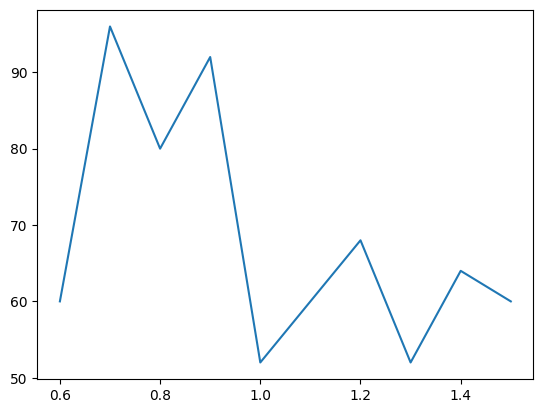

In [20]:
plt.plot(error["scale"], error['word_level_percentage'])

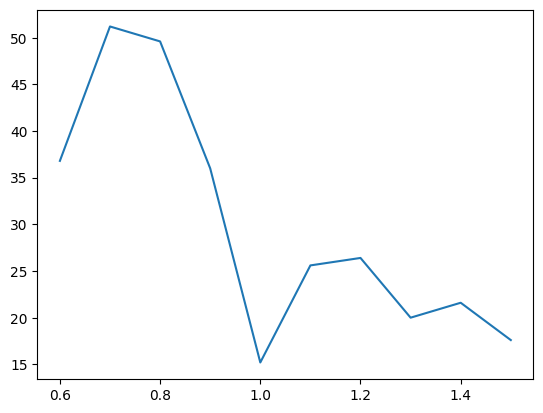

In [21]:
plt.plot(error["scale"], error['char_level_percentage'])

#### Investigate Effects of Contrast Change

In [38]:
error = {"t": [], "word_level": [], "char_level": [], "word_level_percentage": [], "char_level_percentage": []}
for t in range(10, 90, 5):
    error["t"].append(t)
    word_error = 0
    char_error = 0
    for idx, i in enumerate(input_imgs):
      
        img = Image.open(input_folder + i)
        img = np.asarray(img)

        img = adjust_contrast(img, t)

        # sharpen
        kernel = np.array([[0, -1, 0],[-1, 7, -1],[0, -1, 0]])
        img = cv2.filter2D(img, -1, kernel)

        img = img.astype(np.uint8)

        # run ocr
        answer = pytesseract.image_to_string(img)
        answer = answer.upper()

        # validate answer
        o = output_txts[idx]
        with open(output_folder + o) as fp:
            captcha = fp.read()
            
        # error
        hd = hamming_distance(answer, captcha)

        if hd != 0:
            word_error += 1
            char_error += hd
            
    error["word_level"].append(word_error)
    error["char_level"].append(char_error)
    error["word_level_percentage"].append((word_error / len(input_imgs)) * 100)
    error["char_level_percentage"].append((char_error / (len(input_imgs) * 5)) * 100)

error  

{'t': [10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85],
 'word_level': [13,
  14,
  14,
  14,
  14,
  14,
  14,
  14,
  14,
  14,
  14,
  14,
  14,
  14,
  14,
  19],
 'char_level': [29,
  27,
  27,
  27,
  27,
  27,
  27,
  27,
  27,
  27,
  27,
  27,
  27,
  27,
  23,
  50],
 'word_level_percentage': [52.0,
  56.00000000000001,
  56.00000000000001,
  56.00000000000001,
  56.00000000000001,
  56.00000000000001,
  56.00000000000001,
  56.00000000000001,
  56.00000000000001,
  56.00000000000001,
  56.00000000000001,
  56.00000000000001,
  56.00000000000001,
  56.00000000000001,
  56.00000000000001,
  76.0],
 'char_level_percentage': [23.200000000000003,
  21.6,
  21.6,
  21.6,
  21.6,
  21.6,
  21.6,
  21.6,
  21.6,
  21.6,
  21.6,
  21.6,
  21.6,
  21.6,
  18.4,
  40.0]}

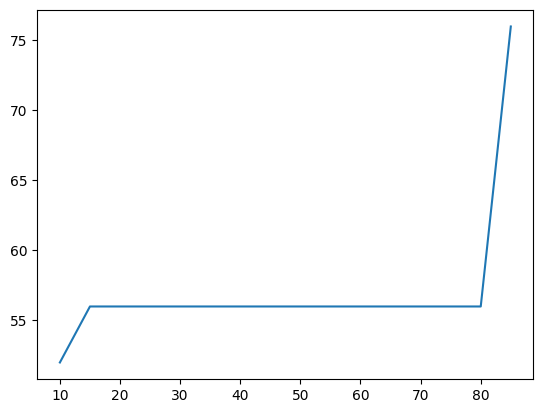

In [39]:
plt.plot(error["t"], error['word_level_percentage'])

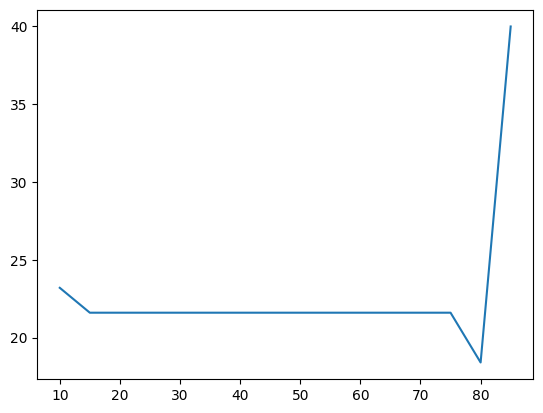

In [40]:
plt.plot(error["t"], error['char_level_percentage'])

### Visualise the Preprocessed Image

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


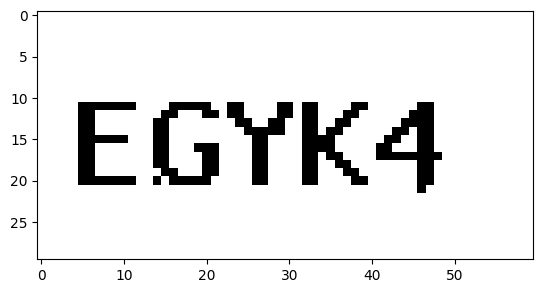

In [30]:
idx = 0
img = Image.open(input_folder + input_imgs[idx])
img = np.asarray(img)
# img = rescale_image(img, 0.5)

# kernel = np.array([[0, -1, 0],[-1, 7, -1],[0, -1, 0]])
# img = cv2.filter2D(img, -1, kernel)

img = adjust_contrast(img, 80)


plt.imshow(img)